In [1]:
import torch
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torchvision import datasets, transforms
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
test_data = datasets.MNIST(
    root="mnist_data", train=False, download=True, transform=transform
)


def image_to_graph(image, label):
    _, row, col = image.shape
    x = image.view(-1, 1)
    edge_index = []
    for i in range(row):
        for j in range(col):
            idx = i * row + j
            if i > 0:
                edge_index.append([idx, (i - 1) * col + j])
            if i < row - 1:
                edge_index.append([idx, (i + 1) * col + j])
            if j > 0:
                edge_index.append([idx, i * row + (j - 1)])
            if j < col - 1:
                edge_index.append([idx, i * row + (j + 1)])

    edge_index = torch.tensor(edge_index).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)


graph_train_data = [image_to_graph(image[0], image[1]) for image in train_data]
graph_test_data = [image_to_graph(image[0], image[1]) for image in test_data]

### Some Aggregation types and common GNN models in pytorch.
| Aggregation Type    | Key Operation                                           | Common GNN Models                                |
|---------------------|--------------------------------------------------------|-------------------------------------------------|
| **Sum**             | Sum features of neighbors                               | GCN                                             |
| **Mean**            | Average features of neighbors                           | GraphSAGE                                       |
| **Max**             | Element-wise max of neighbor features                   | GraphSAGE (Max version)                         |
| **Attention**       | Weighted sum based on learned attention scores          | GAT (Graph Attention Networks)                  |
| **Pooling**         | Hierarchical pooling to downsample graph                | DiffPool, Top-K Pooling                         |

In [3]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32, 64)
        self.fc = torch.nn.Linear(28*28*64, 10)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = x.view(data.num_graphs, -1) 
        x = self.fc(x)
        return F.log_softmax(x, dim=1) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(graph_train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(graph_test_data, batch_size=64, shuffle=False)



def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

for epoch in range(1, 10):
    train_loss = train()
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f},')

Epoch 1, Train Loss: 0.3651,
Epoch 2, Train Loss: 0.2728,
Epoch 3, Train Loss: 0.2422,
Epoch 4, Train Loss: 0.2236,
Epoch 5, Train Loss: 0.2091,
Epoch 6, Train Loss: 0.1915,
Epoch 7, Train Loss: 0.1792,
Epoch 8, Train Loss: 0.1657,
Epoch 9, Train Loss: 0.1578,


In [4]:
def evaluate():
    model.eval()
    correct = 0
    total = 0
    acc = 0
    accuracy_metric = Accuracy(task='multiclass', num_classes=10).to(device)
    accuracy_metric.reset()
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            correct += (predicted == data.y).sum().item()
            total += data.y.size(0)
            acc += accuracy_metric(predicted, data.y)

    return correct / total, acc / len(train_loader)

correct, accu = evaluate()
print(correct)
print(accu)

0.9629333333333333
tensor(0.9629, device='cuda:0')


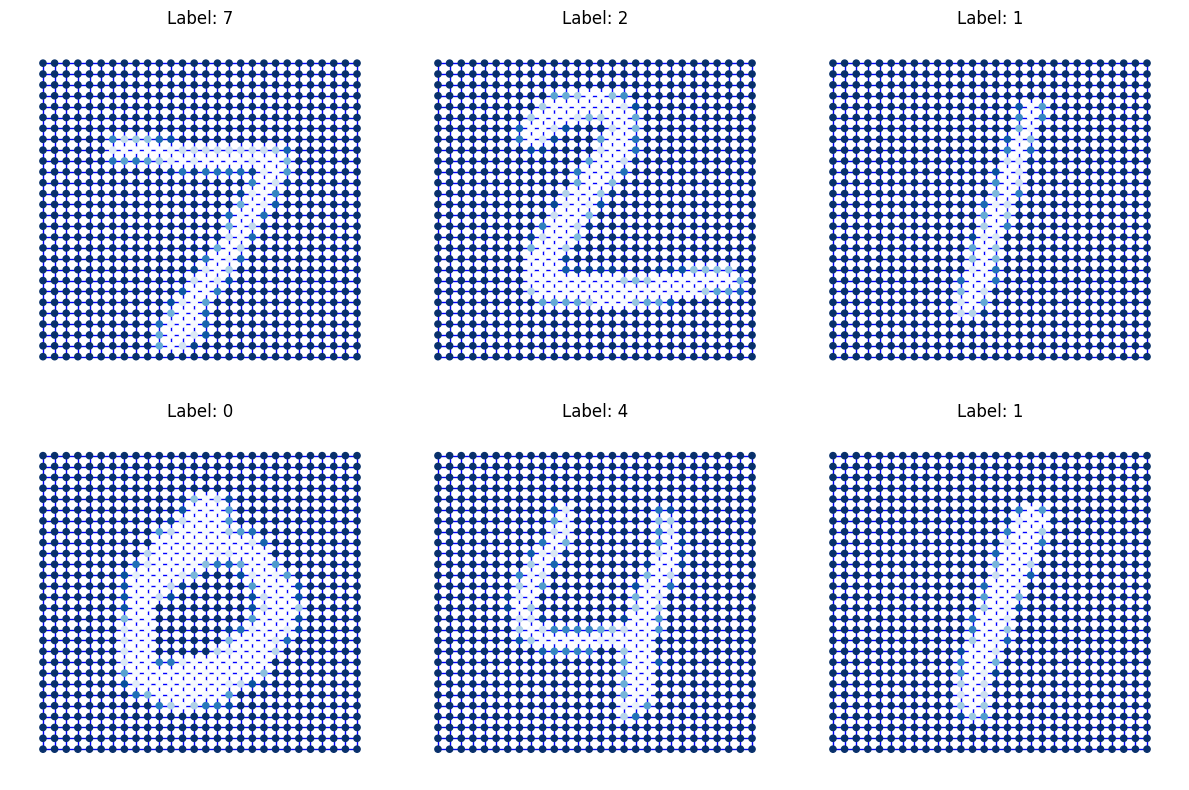

In [8]:
def visualize_graphs(data_list, num_graphs=6):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))  
    axs = axs.flatten() 
    
    for i in range(num_graphs):
        data = data_list[i]
        G = to_networkx(data, to_undirected=True)
        pos = {}
        for row in range(28):
            for col in range(28):
                pos[row * 28 + col] = (col, -row)

        ax = axs[i]
        nx.draw(G, pos=pos, node_size=20, node_color=data.x.numpy().flatten(), cmap='Blues_r', 
                edge_color='blue', with_labels=False, ax=ax)
        ax.set_title(f'Label: {data.y.item()}')
    
    plt.tight_layout()
    plt.show()

visualize_graphs(graph_test_data[:6]) 